In [1]:
from pandas import read_csv
from datetime import datetime
# load data
def parse(x):
    return datetime.strptime(x, '%Y %m %d %H')
dataset = read_csv('raw.csv',  parse_dates = [['year', 'month', 'day', 'hour']], index_col=0, date_parser=parse)
dataset.drop('No', axis=1, inplace=True)
# manually specify column names
dataset.columns = ['pollution', 'dew', 'temp', 'press', 'wnd_dir', 'wnd_spd', 'snow', 'rain']
dataset.index.name = 'date'
# mark all NA values with 0
dataset['pollution'].fillna(0, inplace=True)
# drop the first 24 hours
dataset = dataset[24:]
# summarize first 5 rows
print(dataset.head(5))
# save to file
dataset.to_csv('pollution.csv')

                     pollution  dew  temp   press wnd_dir  wnd_spd  snow  rain
date                                                                          
2010-01-02 00:00:00      129.0  -16  -4.0  1020.0      SE     1.79     0     0
2010-01-02 01:00:00      148.0  -15  -4.0  1020.0      SE     2.68     0     0
2010-01-02 02:00:00      159.0  -11  -5.0  1021.0      SE     3.57     0     0
2010-01-02 03:00:00      181.0   -7  -5.0  1022.0      SE     5.36     1     0
2010-01-02 04:00:00      138.0   -7  -5.0  1022.0      SE     6.25     2     0


In [2]:
from pandas import read_csv
from matplotlib import pyplot
# load dataset
dataset = read_csv('pollution.csv', header=0, index_col=0)
values = dataset.values
# specify columns to plot
groups = [0, 1, 2, 3, 5, 6, 7]
i = 1
# plot each column
pyplot.figure()
for group in groups:
    pyplot.subplot(len(groups), 1, i)
    pyplot.plot(values[:, group])
    pyplot.title(dataset.columns[group], y=0.5, loc='right')
    i += 1
pyplot.show()

<Figure size 640x480 with 7 Axes>

In [3]:
from sklearn import preprocessing 
import pandas as pd
import numpy as np
# convert series to supervised learning
def series_to_supervised(data, columns, n_in=1, n_out=1, dropnan=True):
    n_vars = 1 if type(data) is list else data.shape[1]
    df = pd.DataFrame(data)
    cols, names = list(), list()
    # input sequence (t-n, ... t-1)
    for i in range(n_in, 0, -1):
        cols.append(df.shift(i))
        names += [('%s%d(t-%d)' % (columns[j], j + 1, i)) for j in range(n_vars)]
    # forecast sequence (t, t+1, ... t+n)
    for i in range(0, n_out):
        cols.append(df.shift(-i))
        if i == 0:
            names += [('%s%d(t)' % (columns[j], j + 1)) for j in range(n_vars)]
        else:
            names += [('%s%d(t+%d)' % (columns[j], j + 1, i)) for j in range(n_vars)]
    # put it all together
    agg = pd.concat(cols, axis=1)
    agg.columns = names
    # drop rows with NaN values
    if dropnan:
        clean_agg = agg.dropna()
    return clean_agg

# load dataset
dataset = pd.read_csv('pollution.csv', header=0, index_col=0)


In [4]:
values = dataset.values

In [5]:
# integer encode direction
encoder = preprocessing.LabelEncoder()
values[:,4] = encoder.fit_transform(values[:,4])

In [6]:
# ensure all data is float
values = values.astype('float32')

In [7]:
# normalize features
scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))#fitdata then transform
scaled = scaler.fit_transform(values[:,[1,2,3,4,5,6,7]])

In [8]:
#scaled = np.array(values[:,0],scaled.data)
scaled = np.c_[values[:,0],scaled]
scaled

array([[1.2900000e+02, 3.5294122e-01, 2.4590163e-01, ..., 2.2900114e-03,
        0.0000000e+00, 0.0000000e+00],
       [1.4800000e+02, 3.6764708e-01, 2.4590163e-01, ..., 3.8109892e-03,
        0.0000000e+00, 0.0000000e+00],
       [1.5900000e+02, 4.2647061e-01, 2.2950819e-01, ..., 5.3319666e-03,
        0.0000000e+00, 0.0000000e+00],
       ...,
       [1.0000000e+01, 2.6470590e-01, 2.6229507e-01, ..., 4.1399646e-01,
        0.0000000e+00, 0.0000000e+00],
       [8.0000000e+00, 2.6470590e-01, 2.4590163e-01, ..., 4.2086649e-01,
        0.0000000e+00, 0.0000000e+00],
       [1.2000000e+01, 2.7941179e-01, 2.6229507e-01, ..., 4.2621556e-01,
        0.0000000e+00, 0.0000000e+00]], dtype=float32)

In [9]:
columns = ['pollution',  'dew',  'temp',   'press', 'wnd_dir',  'wnd_spd',  'snow',  'rain']
# frame as supervised learning
reframed = series_to_supervised(scaled,columns, 1, 1)
# drop columns we don't want to predict
reframed.drop(reframed.columns[[9,10,11,12,13,14,15]], axis=1, inplace=True)
print(reframed.head())

   pollution1(t-1)  dew2(t-1)  temp3(t-1)  press4(t-1)  wnd_dir5(t-1)  \
1            129.0   0.352941    0.245902     0.527273       0.666667   
2            148.0   0.367647    0.245902     0.527273       0.666667   
3            159.0   0.426471    0.229508     0.545454       0.666667   
4            181.0   0.485294    0.229508     0.563637       0.666667   
5            138.0   0.485294    0.229508     0.563637       0.666667   

   wnd_spd6(t-1)  snow7(t-1)  rain8(t-1)  pollution1(t)  
1       0.002290    0.000000         0.0          148.0  
2       0.003811    0.000000         0.0          159.0  
3       0.005332    0.000000         0.0          181.0  
4       0.008391    0.037037         0.0          138.0  
5       0.009912    0.074074         0.0          109.0  


In [10]:
label_scaler = preprocessing.MinMaxScaler(feature_range=(0, 1))#fitdata then transform
reframed['pollution1(t-1)'] =label_scaler.fit_transform(reframed.values[:,0].reshape(-1, 1))

regression

In [11]:
reframed['pollution1(t)'] =label_scaler.fit_transform(reframed.values[:,8].reshape(-1, 1))

classify

In [112]:
for i in range(len(reframed.values[:,8])):
    if reframed.values[:,8][i] <= 11:
        reframed.values[:,8][i]  = 0
    elif 11 < reframed.values[:,8][i] <= 23:
        reframed.values[:,8][i]  = 1
    elif 23 < reframed.values[:,8][i] <= 35:
        reframed.values[:,8][i]  = 2
    elif 35 < reframed.values[:,8][i] <= 41:
        reframed.values[:,8][i]  = 3
    elif 41 < reframed.values[:,8][i] <= 47:
        reframed.values[:,8][i]  = 4
    elif 47 < reframed.values[:,8][i] <= 53:
        reframed.values[:,8][i]  = 5
    elif 53 < reframed.values[:,8][i] <= 58:
        reframed.values[:,8][i]  = 6
    elif 58 < reframed.values[:,8][i] <= 64:
        reframed.values[:,8][i]  = 7
    elif 64 < reframed.values[:,8][i] <= 70:
        reframed.values[:,8][i]  = 8
    elif 70 < reframed.values[:,8][i]:
        reframed.values[:,8][i]  = 9
reframed.values[:,8]

array([9., 9., 9., ..., 0., 0., 1.], dtype=float32)

In [12]:
print(reframed.head())

   pollution1(t-1)  dew2(t-1)  temp3(t-1)  press4(t-1)  wnd_dir5(t-1)  \
1         0.129779   0.352941    0.245902     0.527273       0.666667   
2         0.148893   0.367647    0.245902     0.527273       0.666667   
3         0.159960   0.426471    0.229508     0.545454       0.666667   
4         0.182093   0.485294    0.229508     0.563637       0.666667   
5         0.138833   0.485294    0.229508     0.563637       0.666667   

   wnd_spd6(t-1)  snow7(t-1)  rain8(t-1)  pollution1(t)  
1       0.002290    0.000000         0.0       0.148893  
2       0.003811    0.000000         0.0       0.159960  
3       0.005332    0.000000         0.0       0.182093  
4       0.008391    0.037037         0.0       0.138833  
5       0.009912    0.074074         0.0       0.109658  


In [13]:
# split into train and test sets
values = reframed.values
n_train_hours = 365 * 24 * 3
train = values[:n_train_hours, :]
test = values[n_train_hours:, :]

In [14]:
# split into input and outputs
train_X, train_y = train[:, :-1], train[:, -1]
test_X, test_y = test[:, :-1], test[:, -1]

In [15]:
# reshape input to be 3D [samples, timesteps, features]
train_X = train_X.reshape((train_X.shape[0], 1, train_X.shape[1]))
test_X = test_X.reshape((test_X.shape[0], 1, test_X.shape[1]))
print(train_X.shape, train_y.shape, test_X.shape, test_y.shape)

(26280, 1, 8) (26280,) (17519, 1, 8) (17519,)


In [16]:
from keras.utils import np_utils
train_y = np_utils.to_categorical(train_y, num_classes=10)
test_y = np_utils.to_categorical(test_y, num_classes=10)

Using TensorFlow backend.


bi-lstm

In [16]:
from keras.models import *
from keras.layers import *
model = Sequential()
input_shape = (train_X.shape[1], train_X.shape[2])
model.add(Bidirectional(LSTM(units=50),input_shape=input_shape))#,return_sequences=True
model.add(Dropout(0.5))
model.add(BatchNormalization())
#model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

Using TensorFlow backend.


In [17]:
model.compile(loss='mse', optimizer='adam', metrics=['mse'])
history = model.fit(train_X, train_y, epochs=100, batch_size=400, validation_data=(test_X, test_y), verbose=1, shuffle=False)

Train on 26280 samples, validate on 17519 samples
Epoch 1/100
26280/26280 [==============================] - 14s 527us/step - loss: 0.1210 - mean_squared_error: 0.1210 - val_loss: 0.0206 - val_mean_squared_error: 0.0206
Epoch 2/100
26280/26280 [==============================] - 1s 34us/step - loss: 0.0208 - mean_squared_error: 0.0208 - val_loss: 0.0023 - val_mean_squared_error: 0.0023
Epoch 3/100
26280/26280 [==============================] - 1s 37us/step - loss: 0.0052 - mean_squared_error: 0.0052 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 4/100
26280/26280 [==============================] - 1s 33us/step - loss: 0.0034 - mean_squared_error: 0.0034 - val_loss: 0.0019 - val_mean_squared_error: 0.0019
Epoch 5/100
26280/26280 [==============================] - 1s 36us/step - loss: 0.0030 - mean_squared_error: 0.0030 - val_loss: 0.0018 - val_mean_squared_error: 0.0018
Epoch 6/100
26280/26280 [==============================] - 1s 33us/step - loss: 0.0029 - mean_squared_error:

26280/26280 [==============================] - 1s 32us/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0010 - val_mean_squared_error: 0.0010
Epoch 98/100
26280/26280 [==============================] - 1s 33us/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 9.9704e-04 - val_mean_squared_error: 9.9704e-04
Epoch 99/100
26280/26280 [==============================] - 1s 33us/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 9.9363e-04 - val_mean_squared_error: 9.9363e-04
Epoch 100/100
26280/26280 [==============================] - 1s 33us/step - loss: 0.0018 - mean_squared_error: 0.0018 - val_loss: 0.0010 - val_mean_squared_error: 0.0010


autoencoder

In [17]:
from keras.models import *
from keras.layers import *

Using TensorFlow backend.


In [27]:
inputs = Input(shape=(train_X.shape[1], train_X.shape[2]))
lstm = LSTM(128, return_sequences=True, dropout=0.3)(inputs, training=True)
lstm = LSTM(32, return_sequences=False, dropout=0.3)(lstm, training=True)
dense = Dense(50)(lstm)
out = Dense(1)(dense)
model = Model(inputs, out)
model.compile(loss='mse', optimizer='adam', metrics=['mse'])

In [37]:
model = Sequential()
model.add(LSTM(128, activation='relu', input_shape=(train_X.shape[1], train_X.shape[2])))
model.add(RepeatVector(1))
model.add(LSTM(64, activation='relu'))
model.add(Dense(100, activation='relu'))
model.add(Dense(1))          
model.compile(loss='mse', optimizer='adam')

In [38]:
history = model.fit(train_X, train_y, epochs=100, batch_size=500, validation_data=(test_X, test_y), verbose=1, shuffle=False)

Train on 26280 samples, validate on 17519 samples
Epoch 1/100
26280/26280 [==============================] - 3s 125us/step - loss: 0.0088 - val_loss: 0.0088
Epoch 2/100
26280/26280 [==============================] - 1s 31us/step - loss: 0.0069 - val_loss: 0.0081
Epoch 3/100
26280/26280 [==============================] - 1s 29us/step - loss: 0.0031 - val_loss: 0.0011
Epoch 4/100
26280/26280 [==============================] - 1s 27us/step - loss: 9.9243e-04 - val_loss: 0.0021
Epoch 5/100
26280/26280 [==============================] - 1s 31us/step - loss: 0.0034 - val_loss: 0.0092
Epoch 6/100
26280/26280 [==============================] - 1s 30us/step - loss: 0.0028 - val_loss: 0.0023
Epoch 7/100
26280/26280 [==============================] - 1s 29us/step - loss: 0.0013 - val_loss: 8.6543e-04
Epoch 8/100
26280/26280 [==============================] - 1s 29us/step - loss: 9.4642e-04 - val_loss: 0.0013
Epoch 9/100
26280/26280 [==============================] - 1s 29us/step - loss: 0.0010 - 

Epoch 73/100
26280/26280 [==============================] - 1s 38us/step - loss: 7.6108e-04 - val_loss: 7.3060e-04
Epoch 74/100
26280/26280 [==============================] - 1s 32us/step - loss: 7.3133e-04 - val_loss: 7.2363e-04
Epoch 75/100
26280/26280 [==============================] - 1s 27us/step - loss: 7.5110e-04 - val_loss: 7.4014e-04
Epoch 76/100
26280/26280 [==============================] - 1s 29us/step - loss: 8.1873e-04 - val_loss: 7.6037e-04
Epoch 77/100
26280/26280 [==============================] - 1s 29us/step - loss: 8.7165e-04 - val_loss: 7.5089e-04
Epoch 78/100
26280/26280 [==============================] - 1s 29us/step - loss: 7.8732e-04 - val_loss: 7.7642e-04
Epoch 79/100
26280/26280 [==============================] - 1s 30us/step - loss: 7.5558e-04 - val_loss: 9.5089e-04
Epoch 80/100
26280/26280 [==============================] - 1s 29us/step - loss: 9.4369e-04 - val_loss: 0.0010
Epoch 81/100
26280/26280 [==============================] - 1s 29us/step - loss: 9.4

cnn-lstm

In [19]:
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation
from keras.optimizers import Adam
from keras.layers.convolutional import Conv1D
from keras.layers.normalization import BatchNormalization

Using TensorFlow backend.


In [20]:
#model.add(Dropout(0.2))
def baseline_model():
    # design network
    model = Sequential()
    #CNN#
    model.add(Conv1D(filters=64, kernel_size=1, input_shape=(train_X.shape[1], train_X.shape[2])))#kernel1 shape
    model.add(Activation('selu'))
    model.add(Conv1D(filters=64, kernel_size=1))
    model.add(BatchNormalization())
    model.add(Activation('selu'))
#    model.add(Conv1D(filters=64, kernel_size=1))
#    model.add(BatchNormalization())
#    model.add(Activation('selu'))
    ##lstm
    model.add(LSTM(units=128))
#    model.add(Dense(units = 50))
    model.add(Dense(units = 1))#10
    model.add(Activation('sigmoid'))
    adam = Adam(0.001)
    model.compile(loss='mse', optimizer=adam,metrics=['accuracy'])##categorical_crossentropy##
    return model

In [21]:
model = baseline_model()
history = model.fit(train_X, train_y, epochs=50, batch_size=500, validation_data=(test_X, test_y), verbose=1, shuffle=False)

Train on 26280 samples, validate on 17519 samples
Epoch 1/50
26280/26280 [==============================] - 14s 526us/step - loss: 0.0380 - acc: 0.0702 - val_loss: 0.0154 - val_acc: 0.0103
Epoch 2/50
26280/26280 [==============================] - 1s 25us/step - loss: 0.0056 - acc: 0.0709 - val_loss: 0.0086 - val_acc: 0.0103
Epoch 3/50
26280/26280 [==============================] - 1s 33us/step - loss: 0.0023 - acc: 0.0709 - val_loss: 0.0044 - val_acc: 0.0103
Epoch 4/50
26280/26280 [==============================] - 1s 33us/step - loss: 0.0024 - acc: 0.0709 - val_loss: 0.0029 - val_acc: 0.0103
Epoch 5/50
26280/26280 [==============================] - 1s 28us/step - loss: 0.0021 - acc: 0.0709 - val_loss: 0.0019 - val_acc: 0.0103
Epoch 6/50
26280/26280 [==============================] - 1s 24us/step - loss: 0.0017 - acc: 0.0709 - val_loss: 0.0015 - val_acc: 0.0103
Epoch 7/50
26280/26280 [==============================] - 1s 24us/step - loss: 0.0016 - acc: 0.0709 - val_loss: 0.0016 - val_a

rnn

In [17]:
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import SimpleRNN, Activation, Dense
from keras.optimizers import Adam
from keras.layers import Dropout
# build RNN model
model = Sequential()

# RNN cell
model.add(SimpleRNN(
    # for batch_input_shape, if using tensorflow as the backend, we have to put None for the batch_size.
    # Otherwise, model.evaluate() will get error.
    batch_input_shape=(None,  1, 8),       # Or: input_dim=INPUT_SIZE, input_length=TIME_STEPS,
    output_dim=50,
))
model.add(Dense(units = 256,activation = 'relu'))
model.add(Dropout(0.2))
# output layer
model.add(Dense(1))#10
model.add(Activation('relu'))#softmax

# optimizer
adam = Adam(0.001)
model.compile(optimizer=adam,
              loss='mean_squared_error',#categorical_crossentropy
              metrics=['accuracy'])

Using TensorFlow backend.
D:\Anaconda\envs\tensorflow\lib\site-packages\ipykernel_launcher.py:14: UserWarning: Update your `SimpleRNN` call to the Keras 2 API: `SimpleRNN(units=50, batch_input_shape=(None, 1, ...)`
  


In [18]:
# training
BATCH_SIZE = 500
BATCH_INDEX = 0
for step in range(8001):
    # data shape = (batch_num, steps, inputs/outputs)
    X_batch = train_X[BATCH_INDEX: BATCH_INDEX+BATCH_SIZE, :, :]
    Y_batch = train_y[BATCH_INDEX: BATCH_INDEX+BATCH_SIZE]
    cost = model.train_on_batch(X_batch, Y_batch)
    BATCH_INDEX += BATCH_SIZE
    BATCH_INDEX = 0 if BATCH_INDEX >= train_X.shape[0] else BATCH_INDEX

    if step % 500 == 0:
        cost, accuracy = model.evaluate(test_X ,test_y, batch_size=test_y.shape[0], verbose=False)
        print('test cost: ', cost, 'test accuracy: ', accuracy)


test cost:  0.019164105877280235 test accuracy:  0.010331640020012856
test cost:  0.002577272243797779 test accuracy:  0.010331640020012856
test cost:  0.0007650701445527375 test accuracy:  0.010331640020012856
test cost:  0.0007854350260458887 test accuracy:  0.010331640020012856
test cost:  0.0007381096365861595 test accuracy:  0.010331640020012856
test cost:  0.0007902637589722872 test accuracy:  0.010331640020012856
test cost:  0.0007310697692446411 test accuracy:  0.010331640020012856
test cost:  0.000717039976734668 test accuracy:  0.010331640020012856
test cost:  0.0007636155351065099 test accuracy:  0.010331640020012856
test cost:  0.0010662258137017488 test accuracy:  0.010331640020012856
test cost:  0.0007698961417190731 test accuracy:  0.010331640020012856
test cost:  0.0007883048383519053 test accuracy:  0.010331640020012856
test cost:  0.0012919135624542832 test accuracy:  0.010331640020012856
test cost:  0.0008205433841794729 test accuracy:  0.010331640020012856
test cost

mlp

In [46]:
from keras.models import Sequential 
from keras.layers import Dense
from keras.layers import Flatten
model=Sequential()
model.add(Dense(units=256,
                batch_input_shape=(None,  1, 8),
                activation='relu'))                  #使用 ReLu 激活函數
model.add(Dropout(0.2))
model.add(Dense(units=1,                       #建立隱藏層至輸出層連接
                ))           
model.add(Dropout(0.2))
model.add(Flatten())
model.add(Activation('relu'))
# optimizer
adam = Adam(0.001)
model.compile(optimizer=adam,
              loss='mean_squared_error',#categorical_crossentropy
              metrics=['accuracy'])

In [47]:
# training
BATCH_SIZE = 500
BATCH_INDEX = 0
for step in range(8001):
    # data shape = (batch_num, steps, inputs/outputs)
    X_batch = train_X[BATCH_INDEX: BATCH_INDEX+BATCH_SIZE, :, :]
    Y_batch = train_y[BATCH_INDEX: BATCH_INDEX+BATCH_SIZE]
    cost = model.train_on_batch(X_batch, Y_batch)
    BATCH_INDEX += BATCH_SIZE
    BATCH_INDEX = 0 if BATCH_INDEX >= train_X.shape[0] else BATCH_INDEX

    if step % 500 == 0:
        cost, accuracy = model.evaluate(test_X ,test_y, batch_size=test_y.shape[0], verbose=False)
        print('test cost: ', cost, 'test accuracy: ', accuracy)


test cost:  0.010933006182312965 test accuracy:  0.010331640020012856
test cost:  0.0011290544643998146 test accuracy:  0.010331640020012856
test cost:  0.0014449531445279717 test accuracy:  0.010331640020012856
test cost:  0.0015247251139953732 test accuracy:  0.010331640020012856
test cost:  0.0010403221240267158 test accuracy:  0.010331640020012856
test cost:  0.001330885454080999 test accuracy:  0.010331640020012856
test cost:  0.0013454165309667587 test accuracy:  0.010331640020012856
test cost:  0.0012379412073642015 test accuracy:  0.010331640020012856
test cost:  0.0017302795313298702 test accuracy:  0.010331640020012856
test cost:  0.0025450526736676693 test accuracy:  0.010331640020012856
test cost:  0.0012487793574109674 test accuracy:  0.010331640020012856
test cost:  0.0016238195821642876 test accuracy:  0.010331640020012856
test cost:  0.001399829052388668 test accuracy:  0.010331640020012856
test cost:  0.0016858628951013088 test accuracy:  0.010331640020012856
test cost

lstm

In [17]:
from sklearn.metrics import mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Dropout
from keras.layers import Activation
from keras.optimizers import Adam

Using TensorFlow backend.


In [18]:
# create the nn model
#def _create_model(train_X, train_y, test_X, test_y, n_neurons=20, n_batch=50, n_epochs=60, is_stateful=False, has_memory_stack=False, loss_function='mae', optimizer_function='adam', draw_loss_plot=True, output_col_name, verbose=True):
def _create_model(train_X, train_y, test_X, test_y, n_neurons, n_batch, n_epochs, is_stateful, has_memory_stack, loss_function, optimizer_function, draw_loss_plot, output_col_name, verbose):
    """
    train_X: train inputs
    train_y: train targets
    test_X: test inputs
    test_y: test targets
    n_neurons: number of neurons for LSTM nn
    n_batch: nn batch size
    n_epochs: training epochs
    is_stateful: whether the model has memory states
    has_memory_stack: whether the model has memory stack
    loss_function: the model loss function evaluator
    optimizer_function: the loss optimizer function
    draw_loss_plot: whether to draw the loss history plot
    output_col_name: name of the output/target column to be predicted
    verbose: whether to output some debug data
    """
 
    # design network
    model = Sequential()
 
    if is_stateful:
        # calculate new compatible batch size
        for i in range(n_batch, 0, -1):
            if train_X.shape[0] % i == 0 and test_X.shape[0] % i == 0:
                if verbose and i != n_batch:
                    print ("\n*In stateful network, batch size should be dividable by training and test sets; had to decrease it to %d." % i)
                n_batch = i
                break
 
        model.add(LSTM(n_neurons, batch_input_shape=(n_batch, train_X.shape[1], train_X.shape[2]), stateful=True, return_sequences=has_memory_stack))
        if has_memory_stack:
            model.add(LSTM(n_neurons, batch_input_shape=(n_batch, train_X.shape[1], train_X.shape[2]), stateful=True))
    else:
        model.add(LSTM(n_neurons, input_shape=(train_X.shape[1], train_X.shape[2])))
 
    model.add(Dense(1))
 
    model.compile(loss=loss_function, optimizer=optimizer_function)
 
    if verbose:
        print("")
 
    # fit network
    losses = []
    val_losses = []
    if is_stateful:
        for i in range(n_epochs):
            history = model.fit(train_X, train_y, epochs=1, batch_size=n_batch, 
                                validation_data=(test_X, test_y), verbose=0, shuffle=False)
 
            if verbose:
                print("Epoch %d/%d" % (i + 1, n_epochs))
                print("loss: %f - val_loss: %f" % (history.history["loss"][0], history.history["val_loss"][0]))
 
            losses.append(history.history["loss"][0])
            val_losses.append(history.history["val_loss"][0])
 
            model.reset_states()
    else:
        history = model.fit(train_X, train_y, epochs=n_epochs, batch_size=n_batch, 
                            validation_data=(test_X, test_y), verbose=2 if verbose else 0, shuffle=False)
    
    
    if draw_loss_plot:
        pyplot.plot(history.history["loss"] if not is_stateful else losses, label="Train Loss (%s)" % output_col_name)
        pyplot.plot(history.history["val_loss"] if not is_stateful else val_losses, label="Test Loss (%s)" % output_col_name)
        pyplot.legend()
        pyplot.show()
    
    print(history.history)
    #model.save('./my_model_%s.h5'%datetime.datetime.now())
    return (model, n_batch)

normal train


Train on 26280 samples, validate on 17519 samples
Epoch 1/60
 - 15s - loss: 0.0505 - val_loss: 0.0380
Epoch 2/60
 - 4s - loss: 0.0188 - val_loss: 0.0147
Epoch 3/60
 - 5s - loss: 0.0137 - val_loss: 0.0149
Epoch 4/60
 - 6s - loss: 0.0137 - val_loss: 0.0146
Epoch 5/60
 - 5s - loss: 0.0136 - val_loss: 0.0135
Epoch 6/60
 - 4s - loss: 0.0136 - val_loss: 0.0135
Epoch 7/60
 - 4s - loss: 0.0136 - val_loss: 0.0135
Epoch 8/60
 - 4s - loss: 0.0136 - val_loss: 0.0136
Epoch 9/60
 - 5s - loss: 0.0136 - val_loss: 0.0135
Epoch 10/60
 - 5s - loss: 0.0136 - val_loss: 0.0135
Epoch 11/60
 - 5s - loss: 0.0136 - val_loss: 0.0135
Epoch 12/60
 - 4s - loss: 0.0135 - val_loss: 0.0135
Epoch 13/60
 - 4s - loss: 0.0135 - val_loss: 0.0135
Epoch 14/60
 - 4s - loss: 0.0136 - val_loss: 0.0134
Epoch 15/60
 - 5s - loss: 0.0135 - val_loss: 0.0135
Epoch 16/60
 - 4s - loss: 0.0136 - val_loss: 0.0135
Epoch 17/60
 - 5s - loss: 0.0136 - val_loss: 0.0135
Epoch 18/60
 - 4s - loss: 0.0135 - val_loss: 0.0136
Epoch 19/60
 - 4s - l

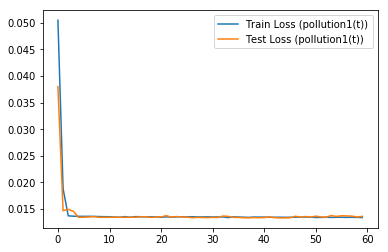

{'loss': [0.050457930363519074, 0.018831335790846938, 0.013732821474043522, 0.013664618028803407, 0.01364248737951002, 0.013639327450808671, 0.013637837791247321, 0.013630858922943004, 0.013589162400057553, 0.013575364456590354, 0.013560083854273373, 0.013499474313569572, 0.013465003059104778, 0.013588259042498671, 0.013464984638240618, 0.013580337552943524, 0.013566154614006754, 0.01353209112684297, 0.013550930512679034, 0.013541717133758542, 0.013448014537789831, 0.013548298766051563, 0.013479320807427206, 0.013528009154284558, 0.013560260109949993, 0.013551685160450862, 0.01357078023756857, 0.013531074703449901, 0.013527917659505166, 0.013544747704239399, 0.013523532824579815, 0.013523442520776124, 0.013525266541753537, 0.013399404812671257, 0.013538514575498395, 0.01351431314175636, 0.013476471485912231, 0.013443881000597327, 0.013504222470547939, 0.013494276682393698, 0.013492991521783014, 0.013467406713874384, 0.013464258018188438, 0.013475807271405198, 0.013453783130458743, 0.01

In [19]:
n_neurons=15
n_batch=50
n_epochs=60
is_stateful=False
has_memory_stack=False
loss_function='mae'
optimizer_function='adam'
draw_loss_plot=True
model, compatible_n_batch = _create_model(train_X, train_y, test_X, test_y, n_neurons, n_batch, n_epochs, 
                                          is_stateful, has_memory_stack, loss_function, optimizer_function, 
                                          draw_loss_plot, 'pollution1(t)', 2)


lstm2

In [22]:
def baseline_model():
    # design network
    model = Sequential()
    model.add(LSTM(256, input_shape=(train_X.shape[1], train_X.shape[2]),return_sequences=True))
    model.add(Dropout(0.2))
    model.add(LSTM(units=256))
    model.add(Dense(units = 256,activation = 'relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units = 1))#10
    model.add(Activation('softmax'))
    adam = Adam(0.001)
    model.compile(loss='mae', optimizer=adam,metrics=['accuracy'])##categorical_crossentropy##
    return model

keras cross vaildation

In [20]:
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.pipeline import Pipeline

In [34]:
estimator = KerasRegressor(build_fn=baseline_model, epochs=5, batch_size=72, verbose=0)#50

In [35]:
X = np.append(train_X,test_X,axis = 0)
y = np.append(train_y,test_y)

In [36]:
seed = 7
np.random.seed(seed)

kfold = KFold(n_splits=10, random_state=seed)
results = cross_val_score(estimator, X, y, cv=kfold)
print("Results: %.2f (%.2f) MSE" % (results.mean(), results.std()))

Results: -0.91 (0.01) MSE


way1

In [23]:
# training
BATCH_SIZE = 500
BATCH_INDEX = 0
model =  baseline_model()
for step in range(4001):
    # data shape = (batch_num, steps, inputs/outputs)
    X_batch = train_X[BATCH_INDEX: BATCH_INDEX+BATCH_SIZE, :, :]
    Y_batch = train_y[BATCH_INDEX: BATCH_INDEX+BATCH_SIZE]
    cost = model.train_on_batch(X_batch, Y_batch)
    BATCH_INDEX += BATCH_SIZE
    BATCH_INDEX = 0 if BATCH_INDEX >= train_X.shape[0] else BATCH_INDEX

    if step % 500 == 0:
        cost, accuracy = model.evaluate(test_X ,test_y, batch_size=test_y.shape[0], verbose=False)
        print('test cost: ', cost, 'test accuracy: ', accuracy)


test cost:  0.08097537606954575 test accuracy:  0.010331640020012856
test cost:  0.02278043143451214 test accuracy:  0.010331640020012856
test cost:  0.015056208707392216 test accuracy:  0.010331640020012856
test cost:  0.0133186811581254 test accuracy:  0.010331640020012856
test cost:  0.01684316247701645 test accuracy:  0.010331640020012856
test cost:  0.014866974204778671 test accuracy:  0.010331640020012856
test cost:  0.01372101716697216 test accuracy:  0.010331640020012856
test cost:  0.021205047145485878 test accuracy:  0.010331640020012856
test cost:  0.014896133914589882 test accuracy:  0.010331640020012856


way2

In [25]:
model = baseline_model()
history = model.fit(train_X, train_y, epochs=50, batch_size=72, validation_data=(test_X, test_y), verbose=2, shuffle=False)

Train on 26280 samples, validate on 17519 samples
Epoch 1/50
 - 4s - loss: 0.0368 - acc: 0.0709 - val_loss: 0.0278 - val_acc: 0.0103
Epoch 2/50
 - 3s - loss: 0.0155 - acc: 0.0709 - val_loss: 0.0151 - val_acc: 0.0103
Epoch 3/50
 - 3s - loss: 0.0147 - acc: 0.0709 - val_loss: 0.0152 - val_acc: 0.0103
Epoch 4/50
 - 3s - loss: 0.0149 - acc: 0.0709 - val_loss: 0.0158 - val_acc: 0.0103
Epoch 5/50
 - 3s - loss: 0.0147 - acc: 0.0709 - val_loss: 0.0167 - val_acc: 0.0103
Epoch 6/50
 - 3s - loss: 0.0146 - acc: 0.0709 - val_loss: 0.0149 - val_acc: 0.0103
Epoch 7/50
 - 3s - loss: 0.0145 - acc: 0.0709 - val_loss: 0.0155 - val_acc: 0.0103
Epoch 8/50
 - 3s - loss: 0.0144 - acc: 0.0709 - val_loss: 0.0151 - val_acc: 0.0103
Epoch 9/50
 - 3s - loss: 0.0143 - acc: 0.0709 - val_loss: 0.0152 - val_acc: 0.0103
Epoch 10/50
 - 3s - loss: 0.0143 - acc: 0.0709 - val_loss: 0.0162 - val_acc: 0.0103
Epoch 11/50
 - 3s - loss: 0.0143 - acc: 0.0709 - val_loss: 0.0157 - val_acc: 0.0103
Epoch 12/50
 - 3s - loss: 0.0141 - 

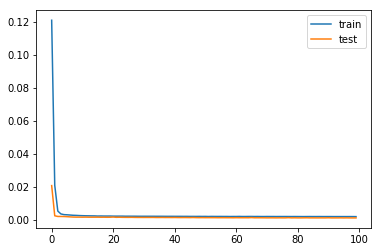

In [18]:
from matplotlib import pyplot
%matplotlib inline
# plot history
pyplot.plot(history.history['loss'], label='train')
pyplot.plot(history.history['val_loss'], label='test')
pyplot.legend()
pyplot.show()


In [19]:
model.evaluate(test_X,test_y, batch_size=72)#test_y.shape[0]

17519/17519 [==============================] - 1s 61us/step


[0.0010041433155561213, 0.0010041433155561213]

In [20]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
bidirectional_1 (Bidirection (None, 100)               23600     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 100)               400       
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 101       
Total params: 24,101
Trainable params: 23,901
Non-trainable params: 200
_________________________________________________________________


evaluate

In [21]:
# make a prediction
yhat = model.predict(test_X)
yhat

array([[0.04422123],
       [0.04189501],
       [0.04227246],
       ...,
       [0.0293982 ],
       [0.02937348],
       [0.02879768]], dtype=float32)

regression

In [22]:
def to_class(pre_pm):
    if pre_pm <= 11:
        return 0
    elif 11 < pre_pm <= 23:
        return  1
    elif 23 < pre_pm <= 35:
        return  2
    elif 35 < pre_pm <= 41:
        return  3
    elif 41 < pre_pm <= 47:
        return  4
    elif 47 < pre_pm <= 53:
        return  5
    elif 53 < pre_pm <= 58:
        return  6
    elif 58 < pre_pm <= 64:
        return  7
    elif 64 < pre_pm <= 70:
        return  8
    elif 70 < pre_pm:
        return  9

In [23]:
count = 0
for i in range(len(yhat)):
    after_pm = label_scaler.inverse_transform(yhat[i].reshape(-1, 1))[0][0]
    pre_pm = label_scaler.inverse_transform(test_y[i].reshape(-1, 1))[0][0]
    if to_class(after_pm) == to_class(pre_pm) :#or abs(to_class(after_pm) - to_class(pre_pm)) == 1:
        count = count + 1
print(count/len(yhat))

0.5013414007648839


class

In [90]:
count = 0
for i in range(len(yhat)):
#    print(max(yhat[i]))
#    print(np.where(yhat[i] == max(yhat[i]))[0][0])
#    np.where(yhat[i] == max(yhat[i]))[0][0] == np.where(test_y[i] == max(test_y[i]))[0][0]
    if np.where(yhat[i] == max(yhat[i]))[0][0] == np.where(test_y[i] == max(test_y[i]))[0][0] or \
    abs(np.where(yhat[i] == max(yhat[i]))[0][0] - np.where(test_y[i] == max(test_y[i]))[0][0]) == 1 :
        count = count + 1
print(count/len(yhat))

0.8228209372681089


In [24]:
inv_yhat = label_scaler.inverse_transform(yhat)
inv_y = label_scaler.inverse_transform(test_y.reshape(-1, 1))

In [25]:
from math import sqrt
from sklearn.metrics import mean_squared_error
rmse = sqrt(mean_squared_error(inv_y, inv_yhat))
print(rmse)
# calculate average error percentage
avg = np.average(inv_y)
error_percentage = rmse / avg
print(error_percentage)

31.498092351400327
0.319133540606213


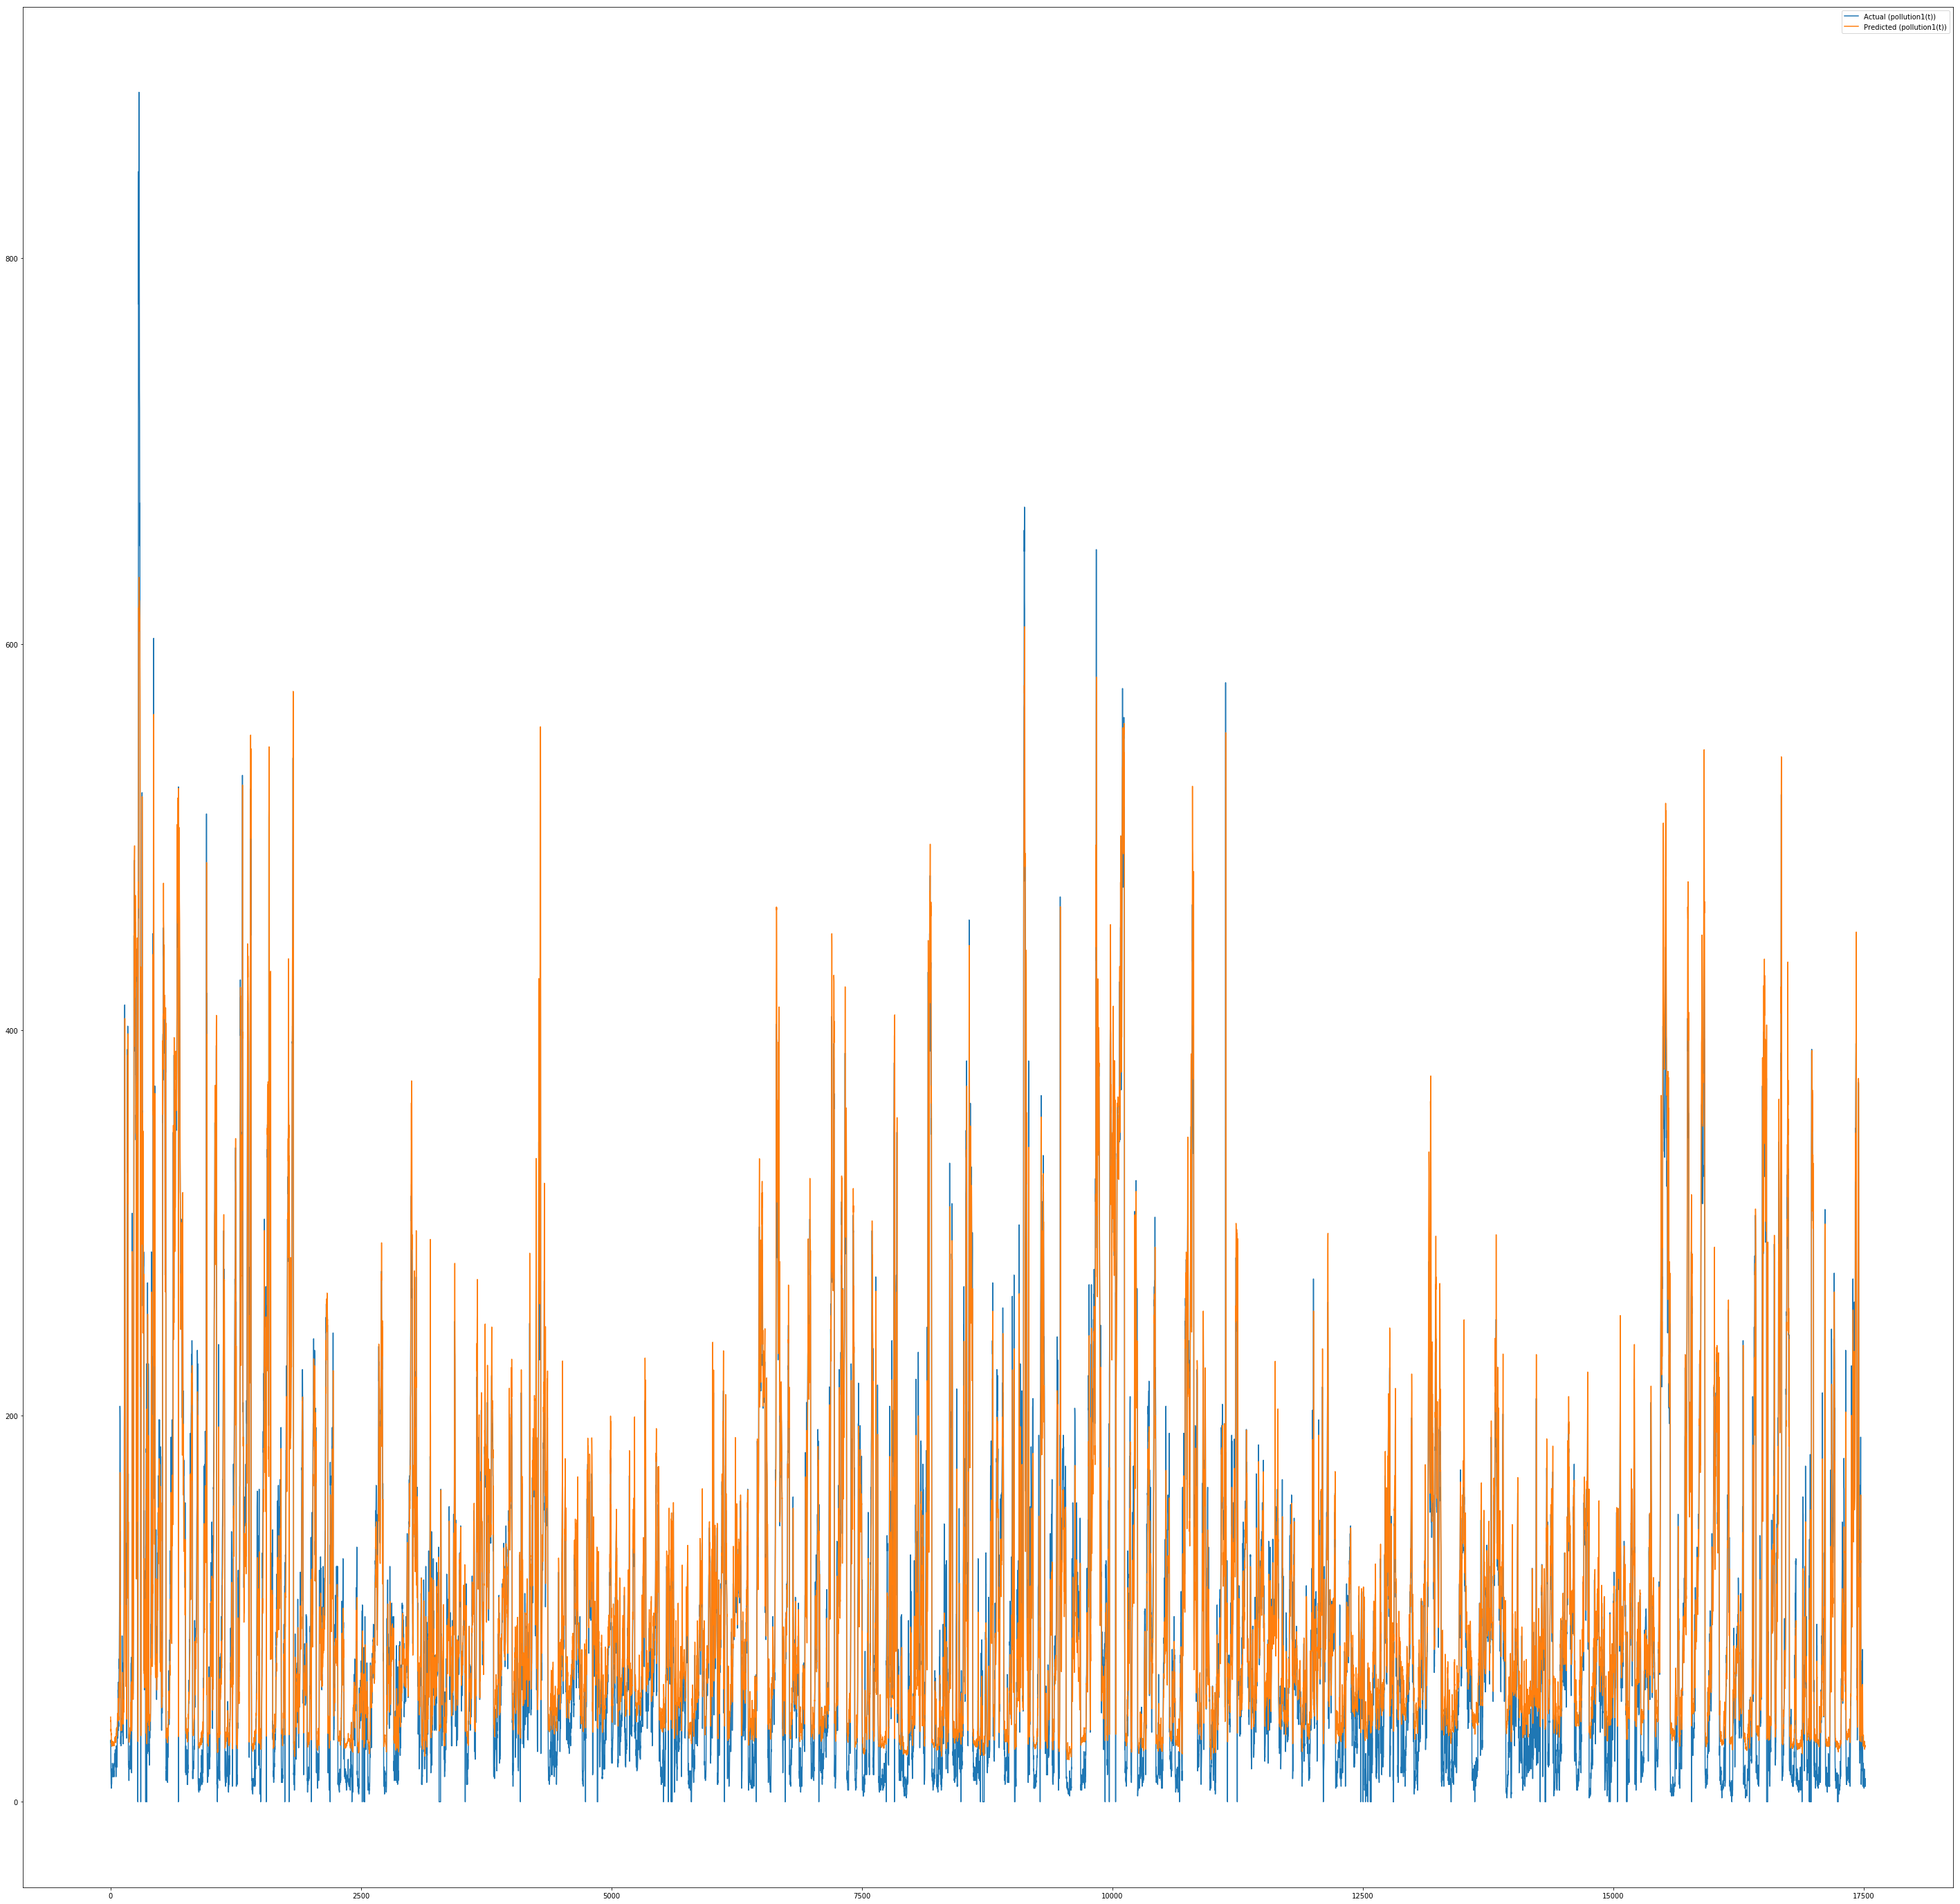

In [26]:
from matplotlib import pyplot
%matplotlib qt5
pyplot.rcParams['figure.figsize'] = (50, 50)
pyplot.plot(inv_y, label="Actual (%s)" % 'pollution1(t)')
pyplot.plot(inv_yhat, label="Predicted (%s)" % 'pollution1(t)')
pyplot.legend()
#pyplot.show()
#pyplot.savefig('test.png')

In [27]:
from sklearn.metrics import explained_variance_score, mean_absolute_error,median_absolute_error,r2_score,mean_squared_error
print("The Explained Variance: %.2f" % explained_variance_score(inv_y, inv_yhat))  
print("The Mean Absolute Error: %.2f degrees Celcius" % mean_absolute_error(inv_y,inv_yhat))  
print("The Median Absolute Error: %.2f degrees Celcius" % median_absolute_error(inv_y, inv_yhat))
print("The r2_score: %.2f" % r2_score(inv_y, inv_yhat)) 
print("The mse: %.2f" % mean_squared_error(inv_y, inv_yhat))

The Explained Variance: 0.89
The Mean Absolute Error: 20.70 degrees Celcius
The Median Absolute Error: 16.60 degrees Celcius
The r2_score: 0.89
The mse: 992.13
